In [151]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from fastparquet import ParquetFile
import os
from ctakes_xml import CtakesXmlParser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib

%matplotlib inline

# Read in parquet files from pre-processing

In [177]:
# do the reading
templates = pd.read_parquet('data/processed_dfs/templates.parquet' )

sentences = pd.read_parquet('data/processed_dfs/sentences.parquet')
mentions = pd.read_parquet('data/processed_dfs/mentions.parquet')
umls = pd.read_parquet('data/processed_dfs/umls.parquet')

In [179]:
sentences.head()

,begin,doc_id,end,sent_id,sentence_number,xmi_id,text
1,10,333701,304,2d8125eb-99e7-414e-95f1-9bfb20664d0d,1,31,"Chief Complaint: 82 yo M with h/o dementia, se..."
2,308,333701,378,2f9f207c-9cde-47d6-9e6d-cda0c864fae2,2,37,"Airway, Inability to Protect (Risk for Aspirat..."
3,382,333701,422,d95f5daf-b9e2-400b-95e3-7bbf36b4ed01,3,43,"Clearance, Cough) , Pneumonia/Aspiration"
5,441,333701,620,034d7746-eeed-4240-b6a4-42a7d6115937,5,55,"Impaired gag, weak cough, unable to clear sec..."
7,635,333701,902,37e5d910-fe36-4124-a414-304b4d98d3de,7,67,"HOB >30 degrees, alb/atr treatment frequency ..."


In [180]:
mentions.head()

,begin,doc_id,end,id,mention_type,ontology_arr,sent_id,xmi_id,text,sentence_number,cui,umls_xmi_id,preferred_text,template_token
0,3680,408714,3683,9a53e800-6b2b-451d-94a6-fb355c76e7a0,ProcedureMention,"[15031, 15021]",000142d2-4690-4a56-8a68-89b5831ed2aa,15045,ABG,58,C0150411,15031,Analysis of arterial blood gases and pH,ProcedureMention
1,1515,442499,1523,1ae0dc2f-b533-4d3a-ac89-d89bfe6fa2b9,MedicationMention,"[6130, 6100, 6150, 6120, 6140, 6110]",001ca15d-0e94-4933-b376-5123e22e5b13,6168,Morphine,17,C0026549,6130,Morphine,MedicationMention
2,1532,442499,1542,742efc2f-1005-4455-b647-6b671bb61e0a,SignSymptomMention,[8825],001ca15d-0e94-4933-b376-5123e22e5b13,8838,air hunger,17,C0231848,8825,Air hunger,SignSymptomMention
3,759,354315,767,e9651709-c7ad-48cc-87b3-e2ae527a8ed8,SignSymptomMention,[19885],002d5022-70f9-4638-84b1-dcf42a6c0e12,19898,services,10,C0557854,19885,Services,SignSymptomMention
4,769,354315,774,80e6aaab-9f60-4ba2-ab89-8a6c97bff1cc,AnatomicalSiteMention,[23649],002d5022-70f9-4638-84b1-dcf42a6c0e12,23662,Renal,10,C0022646,23649,Kidney,AnatomicalSiteMention


In [181]:
templates.head()

,sent_id,sem_template,sentence_number,doc_id,begin,end
0,000142d2-4690-4a56-8a68-89b5831ed2aa,ProcedureMention appear,58,408714,3670,3716
1,001ca15d-0e94-4933-b376-5123e22e5b13,MedicationMention SignSymptomMention,17,442499,1515,1542
2,002d5022-70f9-4638-84b1-dcf42a6c0e12,be be follow SignSymptomMention AnatomicalSite...,10,354315,718,801
3,00385844-a95d-4bb7-a773-70f78a3b035a,continue titrate MedicationMention SignSymptom...,17,432020,1451,1520
4,0046177c-aa3b-4c8d-9554-3efea4802687,be give MedicationMention MedicationMention Me...,5,464828,548,618


### To make templates:
1  Make an empty data frame with the fields to hold template info
2  For each sentence:
    *  Get the predicates for that sentence
        *  trim the frameset after the '.'
    *  Get the mentions
        * Get mention type
        * Append umls cui to end of mention (just take the first one)
    * Order the predicates and mentions by begin offset
    * Combine into a string separated by spaces
    * Write the template and semantic template to the dataframe


In [186]:
print(len(templates))
# templates = templates.drop_duplicates('sem_template')
# print(len(templates))

2774


In [188]:
def get_vectors(df):
    tf = TfidfVectorizer()
    return tf.fit_transform(df['sem_template'])
    
# Only use unique templates
vectors = get_vectors(templates)

vecd = vectors.todense()
print(vectors.shape)





(2774, 374)


In [189]:
cluster_sizes = [70, 80, 90, 100, 110, 120, 125, 130, 140, 150, 200]

for n_cluster in cluster_sizes:
    
    km = KMeans( init='k-means++', max_iter=100, n_init=1,
                 n_clusters=n_cluster, verbose=False)

    km.fit(vectors)
    predictions = km.predict(vectors)
    sil_score = silhouette_score(vectors, predictions, metric='euclidean')
    print(f"Silhouette score for n_clusters={n_cluster}:")
    print(sil_score)
    
km = KMeans( init='k-means++', max_iter=100, n_init=1,
                 n_clusters=120, verbose=False)

km.fit(vectors)
predictions = km.predict(vectors)
sil_score = silhouette_score(vectors, predictions, metric='euclidean')
# print(km.cluster_centers_.shape)

# order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# terms = tf.get_feature_names()
# for i in range(50):
#     print("Cluster %d:" % i, end='')
#     for ind in order_centroids[i, :15]:
#         print(' %s' % terms[ind], end='')
#     print()

Silhouette score for n_clusters=70:
0.3589132719557676
Silhouette score for n_clusters=80:
0.3831557012648031
Silhouette score for n_clusters=90:
0.37868213831132375
Silhouette score for n_clusters=100:
0.3993674287322699
Silhouette score for n_clusters=110:
0.4012596541630207
Silhouette score for n_clusters=120:
0.4172058130840672
Silhouette score for n_clusters=125:
0.40448816578497976
Silhouette score for n_clusters=130:
0.4114589927686263
Silhouette score for n_clusters=140:
0.41636762685641776
Silhouette score for n_clusters=150:
0.4308854561074002
Silhouette score for n_clusters=200:
0.4581207686510411


In [190]:
predictions = km.predict(vectors)

In [191]:
silhouette_score(vectors, predictions, metric='euclidean')


0.40552092055144384

In [192]:

templates['cluster'] = predictions

In [193]:
templates.head()

,sent_id,sem_template,sentence_number,doc_id,begin,end,cluster
0,000142d2-4690-4a56-8a68-89b5831ed2aa,ProcedureMention appear,58,408714,3670,3716,18
1,001ca15d-0e94-4933-b376-5123e22e5b13,MedicationMention SignSymptomMention,17,442499,1515,1542,42
2,002d5022-70f9-4638-84b1-dcf42a6c0e12,be be follow SignSymptomMention AnatomicalSite...,10,354315,718,801,47
3,00385844-a95d-4bb7-a773-70f78a3b035a,continue titrate MedicationMention SignSymptom...,17,432020,1451,1520,32
4,0046177c-aa3b-4c8d-9554-3efea4802687,be give MedicationMention MedicationMention Me...,5,464828,548,618,12


In [194]:
sentences.shape

(2774, 7)

# Add cluster labels to sentences and mentions (entities)

In [195]:
sentences = sentences.merge(templates[['sent_id', 'cluster']], on='sent_id')
mentions = mentions.merge(templates[['sent_id', 'cluster']], on='sent_id')

In [196]:
sentences.head()

,begin,doc_id,end,sent_id,sentence_number,xmi_id,text,cluster
0,10,333701,304,2d8125eb-99e7-414e-95f1-9bfb20664d0d,1,31,"Chief Complaint: 82 yo M with h/o dementia, se...",71
1,308,333701,378,2f9f207c-9cde-47d6-9e6d-cda0c864fae2,2,37,"Airway, Inability to Protect (Risk for Aspirat...",82
2,382,333701,422,d95f5daf-b9e2-400b-95e3-7bbf36b4ed01,3,43,"Clearance, Cough) , Pneumonia/Aspiration",71
3,441,333701,620,034d7746-eeed-4240-b6a4-42a7d6115937,5,55,"Impaired gag, weak cough, unable to clear sec...",42
4,635,333701,902,37e5d910-fe36-4124-a414-304b4d98d3de,7,67,"HOB >30 degrees, alb/atr treatment frequency ...",16


In [197]:
mentions.head()

,begin,doc_id,end,id,mention_type,ontology_arr,sent_id,xmi_id,text,sentence_number,cui,umls_xmi_id,preferred_text,template_token,cluster
0,3680,408714,3683,9a53e800-6b2b-451d-94a6-fb355c76e7a0,ProcedureMention,"[15031, 15021]",000142d2-4690-4a56-8a68-89b5831ed2aa,15045,ABG,58,C0150411,15031,Analysis of arterial blood gases and pH,ProcedureMention,18
1,1515,442499,1523,1ae0dc2f-b533-4d3a-ac89-d89bfe6fa2b9,MedicationMention,"[6130, 6100, 6150, 6120, 6140, 6110]",001ca15d-0e94-4933-b376-5123e22e5b13,6168,Morphine,17,C0026549,6130,Morphine,MedicationMention,42
2,1532,442499,1542,742efc2f-1005-4455-b647-6b671bb61e0a,SignSymptomMention,[8825],001ca15d-0e94-4933-b376-5123e22e5b13,8838,air hunger,17,C0231848,8825,Air hunger,SignSymptomMention,42
3,759,354315,767,e9651709-c7ad-48cc-87b3-e2ae527a8ed8,SignSymptomMention,[19885],002d5022-70f9-4638-84b1-dcf42a6c0e12,19898,services,10,C0557854,19885,Services,SignSymptomMention,47
4,769,354315,774,80e6aaab-9f60-4ba2-ab89-8a6c97bff1cc,AnatomicalSiteMention,[23649],002d5022-70f9-4638-84b1-dcf42a6c0e12,23662,Renal,10,C0022646,23649,Kidney,AnatomicalSiteMention,47


## Get the size of each cluster

In [198]:
pdf = pd.DataFrame(predictions, columns=['cluster'])

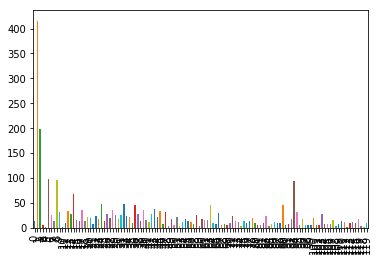

In [199]:
cluster_counts = pdf.groupby('cluster').size().reset_index(name='count')
cluster_counts['count'].plot(kind='bar')

In [200]:
cluster_counts['frequency'] = cluster_counts['count'] / cluster_counts['count'].sum()
cluster_counts.head()

,cluster,count,frequency
0,0,14,0.005047
1,1,416,0.149964
2,2,198,0.071377
3,3,5,0.001802
4,4,2,0.000721
5,5,97,0.034968
6,6,26,0.009373
7,7,13,0.004686
8,8,95,0.034247
9,9,32,0.011536


### Get the distribution of CUIs in each cluster
#### How many clusters on average does a CUI appear in


In [202]:
cui_clust_freq = mentions.groupby(['cui', 'cluster']).size().reset_index(name='cluster_count')
cui_clust_freq.sort_values('cluster_count', ascending=False).head(10)

,cui,cluster,cluster_count
2095,C0270724,1,163
3004,C1145670,1,40
1319,C0035222,1,34
632,C0015967,2,31
3332,C4048181,2,29
910,C0022660,1,28
914,C0022661,1,26
854,C0020649,2,21
1021,C0024467,12,20
2134,C0278060,27,20


In [205]:
num_clusters_per_cui = cui_clust_freq.groupby('cui').size().reset_index(name='num_clusters')
# avg_num_clusters = .agg({'num_clusters': 'mean'})
num_clusters_per_cui.sort_values('num_clusters', ascending=False).head(10)

,cui,num_clusters
323,C0030193,32
683,C0310367,28
843,C0587081,25
112,C0010200,24
902,C0751781,23
221,C0019134,23
279,C0024467,23
412,C0039985,22
179,C0015967,20
859,C0699142,19


### Max and average number of clusters that CUIs appear in

In [206]:
print("Max number of clusters that a cui appears in")
print(num_clusters_per_cui.agg({'num_clusters': 'max'}))

print('Average number of clusters that cuis appear in:')
print(num_clusters_per_cui.agg({'num_clusters': 'mean'}))

Max number of clusters that a cui appears in
num_clusters    32
dtype: int64
Average number of clusters that cuis appear in:
num_clusters    3.199616
dtype: float64


In [213]:
max_clusters = num_clusters_per_cui[num_clusters_per_cui['num_clusters'] == 23]
max_clusters

,cui,num_clusters
221,C0019134,23
279,C0024467,23
902,C0751781,23


### The preferred text of cuis that occur in the most number of clusters

In [214]:
mentions[mentions['cui'].isin(max_clusters['cui'])]['preferred_text'].unique()

array(['Magnesium', 'Dentatorubral-Pallidoluysian Atrophy', 'Heparin'],
      dtype=object)

### Average number of unique CUIs in a cluster

In [216]:
num_cuis_in_cluster_freq = cui_clust_freq[['cui', 'cluster']] \
                                    .groupby('cluster') \
                                    .size() \
                                    .reset_index(name="num_cuis_in_cluster")
num_cuis_in_cluster_freq.sort_values('num_cuis_in_cluster', ascending=False)

,cluster,num_cuis_in_cluster
1,1,179
2,2,117
63,63,111
93,93,103
36,36,94
58,58,87
8,8,85
39,39,78
6,6,78
14,14,71


In [217]:
num_cuis_in_cluster_freq.agg({'num_cuis_in_cluster': 'mean'})

num_cuis_in_cluster    27.783333
dtype: float64

## Get the cluster label frequency by sentence position

In [218]:
cluster_label_by_sentence_pos = pd.crosstab(templates['cluster']
                                            ,templates['sentence_number']
                                           ).apply(lambda x: x / x.sum(), axis=0)
cluster_label_by_sentence_pos

sentence_number,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.0250,0.028571,0.042857,0.032258,0.030769,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,0.253731,0.092105,0.025974,0.0125,0.057143,0.042857,0.016129,0.046154,0.071429,0.092593,...,0.2,0.333333,0.0,0.333333,0.000000,0.333333,0.0,0.0,1.0,0.0
2,0.074627,0.013158,0.012987,0.0625,0.014286,0.042857,0.016129,0.046154,0.114286,0.055556,...,0.2,0.000000,0.0,0.000000,0.666667,0.000000,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018519,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.014925,0.013158,0.090909,0.0625,0.000000,0.000000,0.016129,0.061538,0.028571,0.092593,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.5,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.0000,0.014286,0.014286,0.032258,0.000000,0.014286,0.037037,...,0.0,0.000000,0.5,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0
7,0.000000,0.000000,0.000000,0.0000,0.028571,0.000000,0.000000,0.000000,0.014286,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
8,0.014925,0.000000,0.012987,0.0250,0.028571,0.028571,0.000000,0.015385,0.042857,0.074074,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


## Get the number of documents in each cluster

In [219]:
mentions[mentions['cluster'] == 1]

,begin,doc_id,end,id,mention_type,ontology_arr,sent_id,xmi_id,text,sentence_number,cui,umls_xmi_id,preferred_text,template_token,cluster
14,1527,443072,1531,e50bfffb-721e-4dcc-90d8-dca1d6e45ea5,DiseaseDisorderMention,[6376],009a71c7-cdf5-407d-9595-970d338038ed,6389,Plan,27,C0270724,6376,Infantile Neuroaxonal Dystrophy,DiseaseDisorderMention,1
16,653,441342,656,f8fbe689-662d-4b40-94bc-ee9300ceb500,DiseaseDisorderMention,[8954],00ee58f6-cac3-495d-9f91-70fb8e79764f,8967,HTN,9,C0020538,8954,Hypertensive disease,DiseaseDisorderMention,1
17,658,441342,661,365196de-2e9a-4253-b168-29f73e055d21,DiseaseDisorderMention,[9339],00ee58f6-cac3-495d-9f91-70fb8e79764f,9352,ARF,9,C0022660,9339,"Kidney Failure, Acute",DiseaseDisorderMention,1
18,674,441342,692,b9bb5e80-b1ba-428d-b388-a56daff051df,SignSymptomMention,[10533],00ee58f6-cac3-495d-9f91-70fb8e79764f,10546,infectious process,9,C0006277,10533,Bronchitis,SignSymptomMention,1
19,694,441342,714,1d906a9d-5cc2-4c34-aa8b-4e0fd18de01b,DiseaseDisorderMention,[9207],00ee58f6-cac3-495d-9f91-70fb8e79764f,9220,gastric peptic ulcer,9,C0577559,9207,Mass of body structure,DiseaseDisorderMention,1
20,715,441342,722,3f0026fc-8d41-4519-ab8b-d447c7b70495,DiseaseDisorderMention,[9251],00ee58f6-cac3-495d-9f91-70fb8e79764f,9264,disease,9,C0012634,9251,Disease,DiseaseDisorderMention,1
27,2361,458728,2365,9181f72f-ae82-41aa-8e93-b6a1175e1c75,DiseaseDisorderMention,[17309],01a1e37e-acab-4245-811a-cbdf6d196c3d,17322,Plan,33,C0270724,17309,Infantile Neuroaxonal Dystrophy,DiseaseDisorderMention,1
50,2254,378647,2258,ef0cad34-8f69-47ad-8838-1e48d5c17dfd,DiseaseDisorderMention,[11768],02d1ff23-b8a8-4a61-8528-68c9b9c81683,11781,Plan,31,C0270724,11768,Infantile Neuroaxonal Dystrophy,DiseaseDisorderMention,1
52,868,458691,887,655dda8e-9902-49ba-8d8a-188a001a5688,DiseaseDisorderMention,[12913],02e10911-c5e5-47e5-8de1-c940acb642f6,12926,Respiratory failure,8,C1145670,12913,Respiratory Failure,DiseaseDisorderMention,1
53,900,458691,904,14d04147-09d9-4954-854f-978e645fc3d0,DiseaseDisorderMention,[12264],02e10911-c5e5-47e5-8de1-c940acb642f6,12277,ARDS,8,C0035222,12264,"Respiratory Distress Syndrome, Adult",DiseaseDisorderMention,1


In [223]:
umls[umls['xmi_id'].isin([17309, 11768, 11337, 4456, 15539, 16616, 10061, 13422]) ]

,code,coding_scheme,cui,disambiguated,doc_id,id,preferred_text,tui,xmi_id
148,52713000,SNOMEDCT_US,C0270724,False,458728,4d9e058d-26bb-4c4a-bc40-a78068b10eae,Infantile Neuroaxonal Dystrophy,T047,17309
67,52713000,SNOMEDCT_US,C0270724,False,355788,7c97f733-5d46-4ea1-b21d-9852b9adf99d,Infantile Neuroaxonal Dystrophy,T047,11337
205,52713000,SNOMEDCT_US,C0270724,False,339201,6a9fd3cf-0848-4570-814e-2b14282b0fbd,Infantile Neuroaxonal Dystrophy,T047,13422
152,439569004,SNOMEDCT_US,C0035273,False,438365,12c464c8-e829-491d-95e0-ab1e8923c56b,Resuscitation procedure,T061,17309
77,52713000,SNOMEDCT_US,C0270724,False,350384,f8e98cf6-0afe-46a7-af7d-1cbfcddf852e,Infantile Neuroaxonal Dystrophy,T047,10061
59,312250003,SNOMEDCT_US,C0024485,False,338922,c6ec27c9-7897-45a6-a5cf-899909b0144e,Magnetic Resonance Imaging,T060,4456
96,52713000,SNOMEDCT_US,C0270724,False,442309,007e67f7-69c8-428d-b8ef-d3589e06f2d6,Infantile Neuroaxonal Dystrophy,T047,15539
22,10312003,SNOMEDCT_US,C0032952,False,424894,48223bcb-e16c-46f0-bfdd-1c502c9d388c,Prednisone,T121,10061
99,52713000,SNOMEDCT_US,C0270724,False,355793,b4b962f9-ea4d-4ae3-95f3-d9447e743dc6,Infantile Neuroaxonal Dystrophy,T047,16616
152,439569004,SNOMEDCT_US,C0035273,False,438389,ca5721fd-e5d9-4a5b-ace4-fb68acb89fcc,Resuscitation procedure,T061,17309


In [228]:
sentences[sentences['sent_id'] == 'f918cc4a-2f8b-4c5e-a904-3de84efe714b']

,begin,doc_id,end,sent_id,sentence_number,xmi_id,text,cluster
62,1368,333908,1373,f918cc4a-2f8b-4c5e-a904-3de84efe714b,18,133,Plan:,1


In [229]:
notes = pd.read_parquet('data/note-events.parquet', engine='fastparquet')

In [235]:
notes[notes['ROW_ID'] == 333908]['TEXT'].iloc[0][1368:1372]

'Plan'

# Generating Notes

### Get all the entities for the document

In [503]:
doc_ids = templates['doc_id'].unique()
notes = notes[notes['ROW_ID'].isin(doc_ids)]
notes = notes.reset_index(drop=True)
# notes = notes.drop(['CHARTDATE','CHARTTIME','STORETIME','CGID','ISERROR'],axis=1)


In [504]:
doc = notes.sample(n=1)
doc_id = doc['ROW_ID'].iloc[0]
doc_id

361930

### Drop templates that contain entities not in the document

In [505]:
ents_in_doc = mentions[mentions['doc_id'] == doc['ROW_ID'].iloc[0]]
ments_in_doc = ents_in_doc.mention_type.unique()
# print(ments_in_doc)
ents_in_doc.head()

# get metions where mention_type is in doc entities types
print(len(mentions))
doc_ments = mentions[mentions.cui.isin(ents_in_doc.cui.unique())]
# print(len(doc_ments))


doc_ments.head()

,begin,doc_id,end,id,mention_type,ontology_arr,sent_id,xmi_id,text,sentence_number,cui,umls_xmi_id,preferred_text,template_token,cluster
114,876,361930,881,c37ca5d7-74de-47d4-b437-468c1e6b97e6,AnatomicalSiteMention,[16821],0565613d-e39b-4576-b670-e3e88f5cf982,16834,Blood,8,C0005767,16821,Blood,AnatomicalSiteMention,33
115,884,361930,898,63a2bbd1-c119-4a6c-ba2c-e016b1c5d4a0,ProcedureMention,"[15816, 15806]",0565613d-e39b-4576-b670-e3e88f5cf982,15830,urine cultures,8,C0430404,15816,Urine for culture,ProcedureMention,33
116,923,361930,934,a42518a0-8b0d-4c47-a566-8bfbf5efc069,MedicationMention,[12536],0565613d-e39b-4576-b670-e3e88f5cf982,12549,Antibiotics,8,C0003232,12536,Antibiotics,MedicationMention,33
419,392,361930,405,d1caf679-169f-47c1-8c6a-c1423692fb02,ProcedureMention,[16022],12f3be14-c673-4b85-bebf-faa41151c1b9,16035,stabilization,4,C1293130,16022,Stabilization,ProcedureMention,79
420,423,361930,431,aaf7ca5a-7c5e-4d7d-91c1-6760e05a5269,AnatomicalSiteMention,[16990],12f3be14-c673-4b85-bebf-faa41151c1b9,17003,arterial,4,C0003842,16990,Arteries,AnatomicalSiteMention,79


In [507]:
# get templates that have the corresponding sentence ids from doc_ments
template_candidates = templates[templates.sent_id.isin(doc_ments.sent_id)]
template_candidates.head()

,sent_id,sem_template,sentence_number,doc_id,begin,end,cluster
0,000142d2-4690-4a56-8a68-89b5831ed2aa,ProcedureMention appear,58,408714,3670,3716,18
2,002d5022-70f9-4638-84b1-dcf42a6c0e12,be be follow SignSymptomMention AnatomicalSite...,10,354315,718,801,47
3,00385844-a95d-4bb7-a773-70f78a3b035a,continue titrate MedicationMention SignSymptom...,17,432020,1451,1520,32
4,0046177c-aa3b-4c8d-9554-3efea4802687,be give MedicationMention MedicationMention Me...,5,464828,548,618,12
5,0063b06f-e43d-474b-bf27-b67e474b22de,report SignSymptomMention have come SignSympto...,30,340820,2199,2277,62


### Choose a cluster based on cluster frequency for that sentence position

In [508]:
candidate_cluster_labels = template_candidates.cluster.sort_values().unique()
candidate_clusters = cluster_label_by_sentence_pos.iloc[candidate_cluster_labels]


In [509]:
sent_pos = 0

# remove cluster labels not present in template candidates
selected_cluster = candidate_clusters.sample(
                                        n=1,
                                        weights=candidate_clusters.loc[:,sent_pos]
                        ).iloc[0].name
selected_cluster
# templates_in_cluster = template_candidates[template_candidates['cluster'] == selected_cluster.iloc[0].index]

26

In [510]:
cluster_templates = template_candidates[template_candidates.cluster == selected_cluster]
cluster_templates.head()

,sent_id,sem_template,sentence_number,doc_id,begin,end,cluster
252,17c47df8-37b5-47cd-a1b4-b056fa6553a9,DiseaseDisorderMention SignSymptomMention,40,333908,1956,1979,26
281,1a3970bd-14fd-49e5-a606-ca7f61fc0eaf,SignSymptomMention DiseaseDisorderMention Sign...,0,427806,0,147,26
517,2d836805-7d80-4809-811d-fb3fd0c6c3b1,have DiseaseDisorderMention SignSymptomMention...,14,378629,1135,1220,26
1327,79d5ea31-7213-457a-82af-ed755e165778,give SignSymptomMention SignSymptomMention Dis...,2,442499,255,619,26
1908,b06329da-4fb9-45f6-a384-9e25b425ee7f,SignSymptomMention DiseaseDisorderMention Sign...,11,361823,1163,1254,26


### Choose a template from the cluster base on frequency for that sentence position

In [511]:
# templates_at_pos = cluster_templates[cluster_templates.sentence_number == sent_pos]
template = cluster_templates.sample(n=1)
template

,sent_id,sem_template,sentence_number,doc_id,begin,end,cluster
252,17c47df8-37b5-47cd-a1b4-b056fa6553a9,DiseaseDisorderMention SignSymptomMention,40,333908,1956,1979,26


In [512]:
# sentences[sentences.sent_id == 'deef8a81-b222-4d1f-aa3f-7dfc160cb428'].iloc[0].text

### Fill template blank
#### Choosing text
Select text to fill the template blank based on the frequency of strings for the CUI associated with the mention

In [513]:
# get mentions in this template
template_id = template.iloc[0]['sent_id']
ments_in_temp = mentions[mentions.sent_id == template_id]
ments_in_temp
# Get the sentence for that template
raw_sentence = sentences[sentences.sent_id == template_id]
raw_sentence.iloc[0].text

# Select entities from entities in the document that match that entity type
# 

'gtt if hypotension r/t.'

In [514]:
ments_in_temp
    

,begin,doc_id,end,id,mention_type,ontology_arr,sent_id,xmi_id,text,sentence_number,cui,umls_xmi_id,preferred_text,template_token,cluster
525,1956,333908,1959,4b0ab019-d02c-4f7b-a363-2a24ead17145,DiseaseDisorderMention,"[9255, 9245]",17c47df8-37b5-47cd-a1b4-b056fa6553a9,9269,gtt,40,C0042029,9255,Urinary tract infection,DiseaseDisorderMention,26
526,1963,333908,1974,62064326-c2c6-4490-ab47-c3117e8bcd79,SignSymptomMention,[10289],17c47df8-37b5-47cd-a1b4-b056fa6553a9,10302,hypotension,40,C0020649,10289,Hypotension,SignSymptomMention,26


In [515]:
# ments_in_temp.drop(ments_in_temp.loc[482].name, axis=0)

In [516]:
concepts = umls[umls.cui == ments_in_temp.iloc[0].cui]
concepts.head()

,code,coding_scheme,cui,disambiguated,doc_id,id,preferred_text,tui,xmi_id
50,68566005,SNOMEDCT_US,C0042029,False,453048,ba0d4374-d679-4683-b85a-55e31b20de88,Urinary tract infection,T047,9255
154,68566005,SNOMEDCT_US,C0042029,False,374110,46b50269-81b1-4055-930f-0cf480fe5868,Urinary tract infection,T047,18650


In [517]:
# ents_in_doc

In [518]:
# txt_counts.sample(n=1, weights=txt_counts.cnt).iloc[0].text

In [644]:
def template_filler(template, sentences, entities, all_mentions):
#     print(template.sem_template)
    num_start = len(entities)
    
    template_id = template.iloc[0]['sent_id']
    
    ments_in_temp = all_mentions[all_mentions.sent_id == template_id]
    
    raw_sentence = sentences[sentences.sent_id == template_id]
#     print(f'raw sent df size: {len(raw_sentence)}')
#     print(template_id)
    sent_begin = raw_sentence.iloc[0].begin
    sent_end = raw_sentence.iloc[0].end

    raw_text = raw_sentence.iloc[0].text
    
    replacements = []
#     rows_to_drop = []

#     print('Mention types in template')
#     print(ments_in_temp.mention_type.unique())
#     print('types in entities')
#     print(entities.mention_type.unique())

    for i, row in ments_in_temp.iterrows():
        ents_subset = entities[entities.mention_type == row.mention_type]

        if len(ents_subset) == 0:
            print('Empty list of doc entities')
            print(entities.mention_type)
            print(row.mention_type)
            break
        rand_ent = ents_subset.sample(n=1)
        entities = entities[entities['id'] != rand_ent.iloc[0]['id']]
#         rows_to_drop.append(rand_ent.iloc[0].name)
        
        ent_cui = rand_ent.iloc[0].cui
#         print(ent_cui)
        span_text = get_text_for_mention(ent_cui, all_mentions)
        replacements.append({
            'text' : span_text,
            'begin' : row.begin - sent_begin,
            'end' : row.end - sent_begin,
        })
        
    new_sentence = ''
    for i, r in enumerate(replacements):
        if i == 0:
            new_sentence += raw_text[0 : r['begin'] ]
        else:
            new_sentence += raw_text[replacements[i-1]['end'] : r['begin']]
        new_sentence += r['text']
    
    if(len(replacements) > 1):
        new_sentence += raw_text[replacements[-1]['end'] : ]
        
    # clean up
    num_end = len(entities)
#     print(f"Dropped {num_start - num_end} rows")
    return new_sentence, entities
    
        
        
# Find all the text associated with the cui of the mention in the template
# choose a text span based on frequency
def get_text_for_mention(cui, mentions):
    txt_counts = mentions[mentions.cui == cui].groupby('text').size().reset_index(name='cnt')
    return txt_counts.sample(n=1, weights=txt_counts.cnt).iloc[0].text

# *** Write a full note ***

In [657]:
# Select document to write note for
# doc = notes.sample(n=1)
# doc_id = doc['ROW_ID'].iloc[0]
doc_id = 374185
# Get all the entities in the chosen document

ents_in_doc = mentions[mentions['doc_id'] == doc_id]

new_doc_sentences = []
sent_pos = 0

while len(ents_in_doc) > 0:
#     print(f"Sentence position: {sent_pos}")
#     print(f"Length of remaining entities: {len(ents_in_doc)}")
    # Get list of possible mentions based on CUIs found in the document

    mentions_pool = mentions[(mentions.cui.isin(ents_in_doc.cui.unique()))
                            & (mentions.mention_type.isin(ents_in_doc.mention_type.unique()))]

    # Get template pool based on mentions pool
    # TODO: Need to only choose templates where all the mentions are in `ents_in_doc`
    template_candidates = templates[templates.sent_id.isin(mentions_pool.sent_id)]
    
#     ts = len(template_candidates.sent_id.unique())
#     ms = len(mentions_pool.sent_id.unique())
#     print(ts, ms)
    
    def all_ents_present(row, doc_ents, ments_pool):
        # Get mentions in this template
        all_temp_ments = ments_pool[ments_pool['sent_id'] == row['sent_id']]
        available_mentions = all_temp_ments[all_temp_ments['mention_type'].isin(doc_ents['mention_type'])]
        
        return (len(available_mentions) > 0)
        
    mask = template_candidates.apply(all_ents_present,
                                     args=(ents_in_doc, mentions_pool),
                                     axis=1)
    template_candidates = template_candidates[mask]
#     print(f'num templates: {len(template_candidates)}')
    #If there are no more possible templates then break
    if len(template_candidates) == 0:
        break

    # Get candidate clusters based on template pool

    # Remove the cluster labels that aren't present in template bank
    candidate_cluster_labels = template_candidates.cluster.sort_values().unique()
    candidate_clusters = cluster_label_by_sentence_pos.iloc[candidate_cluster_labels]
#     print(f"Num clusters: {len(candidate_clusters)}")
    # Select cluster based on frequency at sentence position
    selected_cluster = None
    try:
        selected_cluster = candidate_clusters.sample(
                                                n=1,
                                                weights=candidate_clusters.loc[:,sent_pos]
                                ).iloc[0].name
    except:
        # It's possible the clusters we chose don't appear at that position
        # so we can choose randomly
#         print('choosing random cluster')
        selected_cluster = candidate_clusters.sample(n=1).iloc[0].name
#     print('selected cluster:')
#     print(selected_cluster)
    cluster_templates = template_candidates[template_candidates.cluster == selected_cluster]

    # Choose template from cluster at random
    template = cluster_templates.sample(n=1)
    template_id = template.iloc[0]['sent_id']
    
    # Get mentions in the template   
    ments_in_temp = mentions[mentions.sent_id == template_id]

    # Write the sentence and update entities found in the document !!!
    t, ents_in_doc = template_filler(template, sentences, ents_in_doc, mentions_pool)
    new_doc_sentences.append(t)
    sent_pos += 1




In [658]:
'\n'.join(new_doc_sentences)

'Patient transferred in with cooling mattress, temp on adm 100.2\n   axillary\nAssessment:\n    Patient\ns HCT  dropped to 24.4 at 2330 hrs[ aim maintain > 25], NGT\n   in place, initiallt aspirated 20 cc of dark brown blood ,later  got\n   bilious aspirate, HR 90-100bpm b/p stable 100-130 systolic, Started on\n   Clear scopolamine\nPEG\nAssessment:\n    Patient\ns HCT  dropped to 24.4 at 2330 hrs[ aim maintain > 25], NGT\n   in place, initiallt aspirated 20 cc of dark brown blood ,later  got\n   bilious aspirate, HR 90-100bpm b/p stable 100-130 systolic, Started on\n   Clear morphine\nLactulose to keep stools liquid\nBarrier cream to protect maceration,  turn\nEvents :\n          Axillary temp 101.2- Liquid Tylenol\nTITLE:\n   Comfort care (CMO\nAfter the patch has been applied to the back of the  right ear, there\n   has been no secretions & no more Gurgling sounds, patients respirations\n   continue to be shallow but regular.\nO2 changed to\n   aerosol\nPt. given iv T12\nHe was then

In [659]:
notes[notes.ROW_ID == 374185].iloc[0].TEXT

'TITLE:\n   Events :\n          Axillary temp 101.2- Liquid Tylenol given via Peg Tube.\n          Patient very gurgly at the beginning of the shift, has\n   scopolamine patch on him, small thick yellow secretions obtained .\n          IV Morphine given before Turns & positioning.  Gurgling\n   reduced post morphine.\n          Oxygen reduced to 35 % the lowest possible with the aerosol\n   mask as per Resident\ns orders as patient is CMO\n'

### Write until all mentions have been used

In [638]:
mentions.groupby('doc_id').size().reset_index(name='cnt').sort_values('cnt').head(10)

,doc_id,cnt
77,443064,3
35,366305,5
92,464813,7
46,384296,9
95,476781,10
15,341364,12
87,459534,13
90,464653,13
40,374185,14
64,438151,16


In [617]:
mentions[mentions.doc_id == 476781]

,begin,doc_id,end,id,mention_type,ontology_arr,sent_id,xmi_id,text,sentence_number,cui,umls_xmi_id,preferred_text,template_token,cluster
1320,111,476781,123,8743a755-7e36-4400-9f8d-14c89d5b0624,DiseaseDisorderMention,[1682],36c214a8-424f-4b54-a3b2-84f6daf1aef1,1695,Bell's palsy,0,C0376175,1682,Bell Palsy,DiseaseDisorderMention,43
1321,140,476781,149,50b0dd7b-f6bb-4a15-8b75-4b4a48b72e5a,MedicationMention,"[1569, 1539, 1589, 1559, 1529, 1579, 1549, 1519]",36c214a8-424f-4b54-a3b2-84f6daf1aef1,1609,acyclovir,0,C0001367,1569,Acyclovir,MedicationMention,43
3763,299,476781,312,d3679191-ebfc-4a01-8555-34e72d25c81a,SignSymptomMention,"[2007, 1997]",9d69d84d-1184-4bb3-ab7a-bd44c370f375,2021,mental status,2,C0278060,2007,Mental state,SignSymptomMention,27
3764,318,476781,326,3ade634c-9672-49a2-99b1-c7151ac1ac2a,DiseaseDisorderMention,"[1780, 1770]",9d69d84d-1184-4bb3-ab7a-bd44c370f375,1794,Delirium,2,C0011206,1780,Delirium,DiseaseDisorderMention,27
4731,370,476781,374,7aa86886-5eca-445e-8ee4-765175707413,DiseaseDisorderMention,[1726],c63b6ac6-9b5a-4bb7-b5b4-04345e4340bc,1739,Plan,6,C0270724,1726,Infantile Neuroaxonal Dystrophy,DiseaseDisorderMention,1
5891,187,476781,194,22b64b29-2690-4c34-bc40-94cb258a6d91,SignSymptomMention,[1825],f5898ed8-cf97-4c65-b1f3-4d207548b6de,1838,history,1,C0262926,1825,Medical History,SignSymptomMention,38
5892,198,476781,202,fe9fcf13-19f2-4771-b793-553fc9a15f91,AnatomicalSiteMention,[2119],f5898ed8-cf97-4c65-b1f3-4d207548b6de,2132,neck,1,C0027530,2119,Neck,AnatomicalSiteMention,38
5893,207,476781,220,55dead84-b220-4019-bb86-458c9bb85ec7,SignSymptomMention,[1911],f5898ed8-cf97-4c65-b1f3-4d207548b6de,1924,shoulder pain,1,C0037011,1911,Shoulder Pain,SignSymptomMention,38
5894,260,476781,273,be575703-158a-4e44-81a7-a538f1bfb8a4,MedicationMention,[1639],f5898ed8-cf97-4c65-b1f3-4d207548b6de,1652,oral morphine,1,C0026549,1639,Morphine,MedicationMention,38
5895,278,476781,286,2e34af2e-74c5-46d2-8036-944bb889dc6a,MedicationMention,"[1377, 1367]",f5898ed8-cf97-4c65-b1f3-4d207548b6de,1391,percocet,1,C0086787,1377,Percocet,MedicationMention,38
